<a href="https://colab.research.google.com/github/matpg/RL-Agent-for-Unreal-Engine-4/blob/main/Prueba_de_modelo_en_TS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tempfile

from matplotlib import pyplot as plt
import numpy as np
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.platform import gfile
import cv2


TensorFlow 1.x selected.


In [2]:
print(tf.version.VERSION)

1.15.2


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


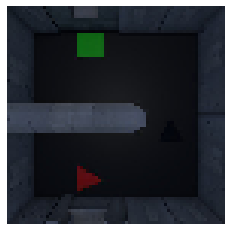

In [ ]:
'''

'''

def img_route(image_count):
  image_set_test, image_set_plt = [], []
  for i in range(image_count):
    file = "/content/drive/MyDrive/Colab Notebooks/modelo ts agentnet/puzzletriangulo(15).jpg"
    img = tf.keras.preprocessing.image.load_img(file, target_size=[72, 72])
    image_set_plt.append(img)
    img_to_test = tf.keras.preprocessing.image.img_to_array(img)
    img_to_test = np.array(img_to_test).reshape(1, 72, 72, 3)
    image_set_test.append(img_to_test)
  return image_set_test, image_set_plt
image_test_index = 0
images_set_test, images_set_plt = img_route(image_test_index+1)
def print_images(image):
  plt.imshow(image)
  plt.axis('off')
  return image

print_images(images_set_plt[image_test_index])
image_to_test = images_set_test[image_test_index]
# EN UE4, SE PODRIA GENERAR LA IMAGEN NEGRA, Y 
# LUEGO, CON DIRECCIONES O PUNTOS DE REFERENCIA DADAS,
# GENERAR EL TRINGULO DEL AGENTE EN COLOR ROJO

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


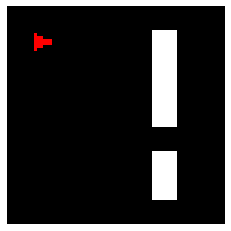

In [235]:

'''
  CARGA DE ARCHIVOS DE OBSERVACION EN FORMATO NUMPY
  IMPRESION DE ARRAYS A IMAGENES
  OBS EPISODE 1 DESDE 00 A 16 
  OBS EPISODE 2 DESDE 17 A 26
  OBS EPISODE 3 DESDE 27 A 39
'''

def obs_route(obsdnumpy_folder, number_ob):
  file = "/content/drive/MyDrive/Colab Notebooks/modelo ts agentnet/archivos de observaciones/obsnumpy"+str(obsdnumpy_folder)+"/obs_array("+str(number_ob)+").npy"
  obs = np.load(file)
  # print(obs)
  # print(obs.shape)
  # np.reshape(obs, newshape=[72, 72, 3])
  obs_img = obs[0]
  return obs, obs_img 

n_folder = 3
'''
  OBS NUMPY 3
  EP1:
    51 - 53
    100
    277 - 288
'''
image_test_index = 288
image_to_test, image_to_plt  = obs_route(n_folder, image_test_index)

def print_images(image):
  plt.imshow(image)
  plt.axis('off')

print_images(image_to_plt)
'''
  PROBAR CON PROGRAMAR ESTE ENTORNO CON EL AGENTE Y LA META
  DE LA MISMA FORMA Y POSICION DEL NIVEL UE4

'''


In [7]:
rand_img = np.random.rand(1, 72, 72, 3)
rand_img2 = rand_img * 9.1

In [234]:
'''
  MODELO TENSORFLOW EN 1.X
  FORMATO PROTOBUF
  INPUT: N, 72, 72, 3
'''

agentnet_save_path = "/content/drive/MyDrive/Colab Notebooks/modelo ts agentnet/archivos modelo ts"

with tf.Session(graph=tf.Graph()) as sess:
  tf.saved_model.loader.load(sess, ["serve"], agentnet_save_path)    
  graph = tf.get_default_graph()
  print(graph.get_operations())
  print(graph.get_all_collection_keys())
  out = sess.run('output/Softmax:0', feed_dict={'input/Ob:0':image_to_test})
  print(out)
  print('Do action number ' + str(np.argmax(out) + 1) + '.')
  # sess.run('output/Softmax:0'

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Colab Notebooks/modelo ts agentnet/archivos modelo ts/variables/variables
[<tf.Operation 'input/Ob' type=Placeholder>, <tf.Operation 'input/Cast' type=Cast>, <tf.Operation 'input/sub/y' type=Const>, <tf.Operation 'input/sub' type=Sub>, <tf.Operation 'input/truediv/y' type=Const>, <tf.Operation 'input/truediv' type=RealDiv>, <tf.Operation 'model/c1/w/Initializer/initial_value' type=Const>, <tf.Operation 'model/c1/w' type=VariableV2>, <tf.Operation 'model/c1/w/Assign' type=Assign>, <tf.Operation 'model/c1/w/read' type=Identity>, <tf.Operation 'model/c1/b/Initializer/Const' type=Const>, <tf.Operation 'model/c1/b' type=VariableV2>, <tf.Operation 'model/c1/b/Assign' type=Assign>, <tf.Operation 'model/c1/b/read' type=Identity>, <tf.Operation 'model/c1/Reshape/shape' type=Const>, <tf.Operation 'model/c1/Reshape' type=Reshape>, <tf.Operation 'model/c1/Conv2D' type=Conv2D>, <tf.Operation 'model/c1/add' type=AddV2>, <tf.Operation '

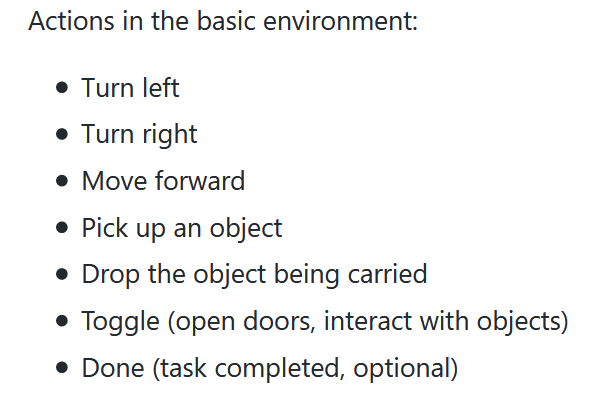

In [ ]:
-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------

In [ ]:
#TENSORFLOW 2
agentnet_save_path = "/content/drive/MyDrive/Colab Notebooks/modelo ts agentnet"
loaded = tf.saved_model.load(sess=None, tags=['serve'], export_dir=agentnet_save_path)
print(list(loaded.signatures.keys()))  # ["serving_default"]

In [ ]:
agentnet = loaded

In [ ]:
infer = loaded.signatures["serving_default"]
print(infer.structured_outputs)

{'action': <tf.Tensor 'output/Softmax:0' shape=(None, 7) dtype=float32>}


In [ ]:
%cd {agentnet_save_path}

/content/drive/MyDrive/Colab Notebooks/modelo ts agentnet


In [ ]:
!saved_model_cli show --dir . --tag_set serve

In [ ]:
new_model = tf.keras.models.load_model(agentnet_save_path)
# Check its architecture
new_model

In [ ]:
#TENSORFLOW 2.0

img = cv2.imread(file)
flag, bts = cv2.imencode('.jpg', img)
inp = [bts[:,0].tobytes()]
loaded = tf.saved_model.load(export_dir=agentnet_save_path)
infer = loaded.signatures["serving_default"]
print(infer.graph)
print(infer.inputs)
print(infer.outputs)
print(infer.structured_input_signature)
print(infer.structured_outputs)
print(infer.name)
print(infer.variables)
out = infer(key=tf.constant(''), image_bytes=tf.constant(img))